说明：  
本文件使用的是 Data clean 1 的数据整理结果（除了 target 列外，全部填充完毕，没有缺失值）。训练 LR 模型。

<font face="微软雅黑" size=5> Contents： </font>  
1. XGBOOST特征重要性  
2. Logistic Regression  
&ensp;&ensp;&ensp;&ensp;2.1 特征标准化  
&ensp;&ensp;&ensp;&ensp;2.2 计算经验相关系数矩阵  
&ensp;&ensp;&ensp;&ensp;2.3 基于相关系数矩阵和XGB特征重要性的特征选择  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.3.1 先del_colinearity1 后 XGB特征重要性  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.3.2 del_colinearity2 内部融合XGB特征重要性  
&ensp;&ensp;&ensp;&ensp;2.4 两种特征选择方式在LR模型上初步尝试  
&ensp;&ensp;&ensp;&ensp;2.5 训练LR模型  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.1 准备数据集  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.2 GridSearchCV交叉验证粗取最佳超参数  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.3 对验证集进行预测并求得AUC---法1  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.4 对验证集进行预测并求得AUC---法2  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.5 查看并分析详细信息  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.6 hyperopt求取最佳超参数  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.7 交叉验证  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.8 训练最终LR模型并预测未知样本集  
3. 提交结果  


In [1]:
import numpy as np
import pandas as pd
import time
from scipy import special
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,rand
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import time
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# 1. XGBOOST 特征重要性

1. 将训练集二八分划分成训练集和验证集（shuffle+stratify），训练集和验证集同时给到XGB，训练出XGB模型。通过feature_importance得到所有特征的重要性，并用表格法和图示法展示。
2. 用此模型小试一下，对验证集进行概率预测（关注排序而非真实的预测概率绝对值）。自定义 ks_statistic函数计算K-S统计量值为0.45， ks_curve函数画K-S图线。

In [10]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y_tr,
                    test_size = 0.2, shuffle=True, stratify=y_tr, 
                            random_state = 0)

scale_pos_weight_value=len(y_tr_train[y_tr_train==0])/len(
       y_tr_train[y_tr_train==1]) # XGB默认label==0是反类，label==1是正类。
scale_pos_weight_value1=len(y_tr_test[y_tr_test==0])/len(
           y_tr_test[y_tr_test==1])

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)
negative number/positive number in y_tr_train is: 6.7441006816990035
negative number/positive number in y_tr_test is: 6.746153846153846


In [12]:
modelXGB1 = XGBClassifier(
    max_depth=6,    
    n_estimators=1000,                  
    objective='binary:logistic',        
    scale_pos_weight = scale_pos_weight_value,  
    seed = 1,                           
    missing = np.nan)

timestart = time.time()
modelXGB1.fit(X_tr_train,y_tr_train,
        eval_set = [(X_tr_train,y_tr_train),(X_tr_test, y_tr_test)],
       eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,
              verbose = True)

[0]	validation_0-logloss:0.669162	validation_0-auc:0.781234	validation_1-logloss:0.670913	validation_1-auc:0.743866
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.649867	validation_0-auc:0.789589	validation_1-logloss:0.652907	validation_1-auc:0.758868
[2]	validation_0-logloss:0.633333	validation_0-auc:0.794852	validation_1-logloss:0.638207	validation_1-auc:0.758414
[3]	validation_0-logloss:0.619523	validation_0-auc:0.798146	validation_1-logloss:0.625986	validation_1-auc:0.759382
[4]	validation_0-logloss:0.60772	validation_0-auc:0.80188	validation_1-logloss:0.615571	validation_1-auc:0.762851
[5]	validation_0-logloss:0.597535	validation_0-auc:0.80507	validation_1-logloss:0.60698	validation_1-auc:0.764637
[6]	validation_0-logloss:0.587915	validation_0-auc:0.811228	validation_1-logloss:0.599076	validation_1-auc:0.766086
[7]	validation_0-logloss:0.580161	v

[70]	validation_0-logloss:0.42749	validation_0-auc:0.91319	validation_1-logloss:0.495111	validation_1-auc:0.787057
[71]	validation_0-logloss:0.426462	validation_0-auc:0.913775	validation_1-logloss:0.494496	validation_1-auc:0.787303
[72]	validation_0-logloss:0.425339	validation_0-auc:0.914567	validation_1-logloss:0.493858	validation_1-auc:0.787172
Stopping. Best iteration:
[62]	validation_0-logloss:0.43844	validation_0-auc:0.905732	validation_1-logloss:0.500588	validation_1-auc:0.787411

Time: 171.69 seconds


In [15]:
featurenames = X_tr_train.columns
FeatureImportance = pd.DataFrame(data = modelXGB1.feature_importances_, 
                    index = featurenames, columns = ['feature importance'])
FeatureImportance = FeatureImportance.sort_values(
    by = ['feature importance'], ascending=False)

fig1 = plt.figure(figsize = (8,16))
ax1 = fig1.add_subplot(111)
plot_importance(modelXGB1, ax1, height=0.8, xlim=None, ylim=None, 
                        title='Feature importance', xlabel='F score', 
                       ylabel='Features',importance_type='weight', 
                grid=True,max_num_features=50)
plt.show()

&ensp;&ensp;赛题选择的这个K-S统计量，只与被预测样本的排序有关，而与真正的逾期概率值本身的绝对大小无关。get到这点很重要。所以在训练模型的时候，我们关注的就仅仅是预测的排序，而非预测为违约的实际概率值。这种情况，用AUC作为评价函数就比较好，此指标只与排序有关，与预测的概率值的绝对大小无关。而且，这种情况下，若总体样本不平衡，则可以使用 scale_pos_weight或class_weight参数调整类别不平衡。（调整这样的参数会影响到 预测的概率值的绝对大小，但对提高预测排序的准确性有帮助）。

In [18]:
def ks_statistic(y_true,y_predicted_proba):
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,
                                           pos_label=1)
    return abs(tpr-fpr).max()


def ks_curve(y_true,y_predicted_proba):
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,
                                           pos_label=1)
    
    font1 = {'family': 'Calibri','weight': 'normal','size': 18} 
    font2 = {'family': 'Calibri','weight': 'normal','size': 23} 
    
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    ax.plot(thresholds,1.0-tpr,label="overdue",color="navy")
    ax_t = ax.twinx()
    ax_t.plot(thresholds,1.0-fpr,label="normal",color="g")
    ax.plot(thresholds,tpr-fpr,label="K-S",color="darkorange")
    ax.legend(loc=2)
    ax_t.legend(loc=9)
    ax_t.set_xlim(0.0, 1.0)
    ax_t.set_ylim(0.0, 1.0)
    ax.set_title('K-S curve',fontdict=font2 ) 
    ax.set_xlabel('threshold',fontdict=font1,labelpad= 2)  
    ax.set_ylabel('True Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_ylabel('False Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
       
    plt.show()

In [19]:
y_predict_proba1 = modelXGB1.predict_proba(X_tr_test, ntree_limit=58)
ks_value1 = ks_statistic(np.array(y_tr_test),y_predict_proba1[:,1])
print("ks_value1 is: ",ks_value1)

ks_value1 is:  0.4478387063335752


# 2. Logistic Regression

1. 对训练集中的所有特征进行标准化（包括onehot encoder得到的特征 和 连续型数值特征），记录每个特征的均值方差，将其应用到未知样本集，对它们进行标准化。
2. 对训练集的所有特征计算相关系数矩阵。
3. 找出相关系数>0.7的变量，只保留其中之一，结合XGB的特征重要性，完成特征筛选。

## 2.2 计算经验相关系数矩阵

In [26]:
X_tr_correlation_matrix = covariance.empirical_covariance(X_tr_standard)
print("shape of X_tr_correlation_matrix is:",X_tr_correlation_matrix.shape)

shape of X_tr_correlation_matrix is: (424, 424)


### 2.3.1 先 del_colinearity1 后 XGB特征重要性    

&ensp;&ensp;先删除一部分特征，使得剩下的特征两两之间的相关系数<0.8.然后，再从剩下的特征中删除在XGB特征重要性排序中处于后10% 的特征，最后剩下的特征，是用于训练LR模型的特征。

In [28]:
def colinearity(correlation_matrix):
    num=correlation_matrix.shape[0] # num是相关矩阵的行数
    L=[]
    for i in range(num-1):  # 只需要检查不含主对角线的上三角形。
        for j in range(i+1,num):
            if correlation_matrix[i,j]>0.8:
                L.append([i,j]) # 把相关系数大于0.8的特征对添加到 L中。L是二维列表。
    
    return L

In [29]:
L = colinearity(X_tr_correlation_matrix)
print(len(L))

869


In [31]:
# 424 个字段变量，一共有 89676 对。

variancepair = special.comb(424,2)  
# scipy计算排列组合（从424个字段中挑选两个组成一对，总的方法数为 89676）。
print("There's %d variancepair." % variancepair)

There's 89676 variancepair.


In [32]:
colinearity_counts = pd.value_counts(np.array(L).flatten())
colinearity_counts = pd.DataFrame(colinearity_counts).reset_index()
colinearity_counts.columns = ["colindex","colinearity_counts"]  # 改列名

In [34]:
colinearity_pairs = pd.DataFrame(L,columns=["col1","col2"])

There is 869 pairs of features have correlation coefficient more than 0.8.


,col1,col2
0,3,8
1,3,13
2,3,19
3,8,13


In [35]:
参数 colinearity_pairs 是一个dataframe，它记录了当前 424 个特征中，
所有的 相关系数>0.8的特征对。
# 此表有两列，都是特征索引，此dataframe的每一行代表一个特征对，
它们之间的相关系数>0.8.此 dataframe里的特征对是无重复的。
# 首先，由 colinearity_pairs计算其中每个特征出现的次数，并排序，
得到 colinearity_counts这个dataframe，里面有两列，
# 左列 colindex 是特征的索引值，右列 colinearity_counts 
是它在colinearity_pairs里出现的次数，也就是说，
# 这个特征与多少个其它特征强相关。并按照这个次数由大到小排序。

# 然后，思路是这样的，若有一对特征对强相关，则把其中之一删掉即可，
另一个可以保留。而非两个全删。而我现在需要做的就是，把
# colinearity_counts里的colindex列里的特征择性删除一部分，
使得剩下的变量之间不再强相关，而且这时， colinearity_pairs会变空，
# 也就是剩下的变量里不再有强相关的特征对。并用 D 列表记录下了需要删掉的特征的索引。
# 所以，我根据 colinearity_counts 的排序，
先把排在首位的特征提取出来，把
# colinearity_pairs 里 所有含此特征的特征对全部删掉，然后把此特征记录在D里，
然后检查 colinearity_pairs 看是否为空，如果
# 不是空，则继续选择 colinearity_counts里的特征，
把colinearity_pairs 里 所有含此特征的特征对全部删掉，然后把此特征记录在D里，
# 然后检查 colinearity_pairs 看是否为空，若为空，则跳出循环，返回 D。
# 缺点：本函数还是具有一定盲目性的，因为colinearity_counts排序中，
很多变量是相同次数的，但就是依据 colinearity_counts的排序
# 取逐个尝试了。其实我觉得如果改进的话，可以看看相同次数的特征，
它们和其它特征的相关性，虽然都不到0.8，但是还是可能会有不同，
# 尽量删除和其它变量相关性较强的。
# 这里我选择的删除顺序是按照 与其它变量存在强相关的次数，按照此次数排序，逐个删除的。
我认为还有一种思路，就是使用 XGB得到的特征
# 重要性，从最不重要的特征开始尝试，逐个删除，使得留下来的是重要的特征，
也就是 del_colinearity2 函数。

def del_colinearity1(colinearity_pairs):
    
    colinearity_counts = pd.value_counts(
        np.array(colinearity_pairs).flatten())
    colinearity_counts = pd.DataFrame(colinearity_counts).reset_index()
    colinearity_counts.columns = ["colindex","colinearity_counts"] 
    
    c = colinearity_pairs.columns
    D=[]
    
    for i in colinearity_counts["colindex"]:
        print("use %d to delete" % i)
        n0 = len(colinearity_pairs)
        print("before delete,the pair number is:",n0)
        
        colinearity_pairs = colinearity_pairs[
            (~colinearity_pairs[c[0]].isin([i]))&(
                ~colinearity_pairs[c[1]].isin([i]))]
        
        n1 = len(colinearity_pairs)
        print("after delete, the pair number is:",n1)
        
        if n1<n0:                     
            print("append %d to D" % i) 
            D.append(i)
        
        if len(colinearity_pairs)==0:
            print("now colinearity_pairs is null,break")
            break
    
    return D

In [ ]:
del_features1 = del_colinearity1(colinearity_pairs)

In [ ]:
C = [i for i in range(len(data_column_names))]
choose = list( set(C)-set(del_features1) )
tmp1 = pd.DataFrame(data_column_names)
data_column_names_delcolinear1 = tmp1.iloc[choose]

In [ ]:
featureimportance = pd.DataFrame(modelXGB1.feature_importances_)
featureimportance = featureimportance.reset_index() 
featureimportance.columns=["featureindex","featureimportance"]
featureimportance.sort_values(by="featureimportance",ascending=True,inplace=True)

In [45]:
featureimportance.head()

,featureindex,featureimportance
421,421,0.0
45,45,0.0
162,162,0.0
25,25,0.0
27,27,0.0


In [46]:
tmp3 = np.array(data_column_names_delcolinear1.index) 
tmp4 = np.array(featureimportance[
    "featureindex"][0:int(len(featureimportance)*0.1)]) 

data_column_names_delcolinear1_1 = np.setdiff1d(tmp3,tmp4)
tmp5 = pd.DataFrame(data_column_names)
data_column_names_delcolinear1_1 = tmp5.iloc[
    data_column_names_delcolinear1_1]
data_column_names_delcolinear1_1.columns = ["featurename"]


The number of features without colinear&most important is: 154


### 2.3.2 del_colinearity2内部融合XGB特征重要性  
  
&ensp;&ensp;根据XGB得到的特征重要性，由小到大，逐个删除，每次删除后都检查剩下的特征还有无相关系数>0.8的特征对，直到剩下的所有特征两两之间的相关系数都<=0.8，这些特征就是训练LR模型需要的特征。

In [48]:

def del_colinearity2(colinearity_pairs,XGB_feature_importance):
    
    c = colinearity_pairs.columns
    D=[]  # 记录需要删除的特征的索引。
    
    for i in XGB_feature_importance["featureindex"]:
        print("use %d to delete" % i)
        n0 = len(colinearity_pairs)
        print("before delete,the pair number is:",n0)
        
        colinearity_pairs = colinearity_pairs[
            (~colinearity_pairs[c[0]].isin([i]))&(
                ~colinearity_pairs[c[1]].isin([i]))]
        n1 = len(colinearity_pairs)
        print("after delete, the pair number is:",n1)
        
        if n1<n0:                   
            print("append %d to D" % i) 
            D.append(i)     
            
        
        print("-----------------------")
        
        if len(colinearity_pairs)==0:
            print("now colinearity_pairs is null,break")
            break
    
    return D

In [ ]:
del_features2 = del_colinearity2(colinearity_pairs,featureimportance)

In [50]:
C = [i for i in range(len(data_column_names))]
choose = list( set(C)-set(del_features2) )
tmp2 = pd.DataFrame(data_column_names)
data_column_names_delcolinear2 = tmp2.iloc[choose]
data_column_names_delcolinear2.columns = ["featurename"]

269

## 2.4 两种特征选择方式在 LR模型上初步尝试

&ensp;&ensp;XGBOOST算特征重要性时曾将训练集data_tr的字段变量部分X_tr和目标变量部分y_tr，三七分成训练集X_tr_train, y_tr_train,和验证集 X_tr_test, y_tr_test。这里沿用此划分。然后，将训练集X_tr_train标准化得X_tr_train_std，将得到的均值方差用来标准化验证集X_tr_test，得到X_tr_test_std。（注意，不能沿用之前计算相关系数矩阵时得到的标准化数据，因为那个是将整个训练集进行标准化，如果这样再划分训练集验证集的话，两者就是相关的，这样做是不对的。应该把训练集的标准用到验证集上。）然后，分别用 2.3.1 选择得到的特征、2.3.2选择得到的特征 在 训练集上试，在验证集上测试结果。评分以 AUC指标为准。粗略评价2.3.1 、2.3.2哪种特征选择结果更好。

In [ ]:


# 标准化 训练集的字段变量部分 X_tr_train 为 X_tr_train_standard。
# 用训练集的均值和方差标准化 验证集的字段变量部分 X_tr_test 为 X_tr_test_standard。

scaler2 = StandardScaler()
scaler2.fit(X_tr_train)
X_tr_train_standard = scaler2.transform(X_tr_train)
X_tr_test_standard = scaler2.transform(X_tr_test)
print("shape of X_tr_train_standard is: ",X_tr_train_standard.shape)
print("shape of X_tr_test_standard is: ",X_tr_test_standard.shape)


# 将标准化的训练集 X_tr_train_standard 转化为 dataframe并命名为 X_tr_train_std 。
# 将标准化的验证集 X_tr_test_standard 转化为 dataframe并命名为 X_tr_test_std 。

X_tr_train_std = pd.DataFrame(X_tr_train_standard,columns=data_column_names)
X_tr_test_std = pd.DataFrame(X_tr_test_standard,columns=data_column_names)
print("shape of X_tr_train_std is: ",X_tr_train_std.shape)
print("shape of X_tr_test_std is: ",X_tr_test_std.shape)

In [57]:
# 这里，对训练集和验证集的X部分使用 2.3.1的特征选择法data_column_names_delcolinear1_1进行特征选择。
# 得到 X_tr_train_std_choose1可用于训练，X_tr_test_std_choose1可用于验证。它们都只包含 152 个特征。

X_tr_train_std_choose1 = X_tr_train_std.loc[:,
                        data_column_names_delcolinear1_1["featurename"]]
X_tr_test_std_choose1 = X_tr_test_std.loc[:,
                    data_column_names_delcolinear1_1["featurename"]]

shape of X_tr_train_std_choose1 is: (44304, 154)
shape of y_tr_train is: (44304,)
shape of X_tr_test_std_choose1 is: (11077, 154)
shape of y_tr_test is: (11077,)


In [58]:
# 这里，对训练集和验证集的X部分使用 2.3.2的特征选择法data_column_names_delcolinear2进行特征选择。
# 得到 X_tr_train_std_choose2可用于训练，X_tr_test_std_choose2可用于验证。它们都只包含 159 个特征。

X_tr_train_std_choose2 = X_tr_train_std.loc[:,
                            data_column_names_delcolinear2["featurename"]]
X_tr_test_std_choose2 = X_tr_test_std.loc[:,
                            data_column_names_delcolinear2["featurename"]]

shape of X_tr_train_std_choose2 is: (44304, 155)
shape of y_tr_train is: (44304,)
shape of X_tr_test_std_choose2 is: (11077, 155)
shape of y_tr_test is: (11077,)


In [59]:
args ={'C':1}     
LR_parameter = {"penalty": "l2","tol": 1e-4,"class_weight": 'balanced', 
                'solver': 'liblinear','max_iter':1000,'random_state':1}  
LR_parameter.update(args)


modelLR1 = LogisticRegression(**LR_parameter)
modelLR1.fit(X_tr_train_std_choose1, y_tr_train)
proba_prediction1 = modelLR1.predict_proba(X_tr_test_std_choose1)


modelLR2 = LogisticRegression(**LR_parameter)
modelLR2.fit(X_tr_train_std_choose2, y_tr_train)
proba_prediction2 = modelLR2.predict_proba(X_tr_test_std_choose2)

In [60]:
tmp6 = pd.DataFrame(y_tr_test,columns=["target"]
                   ).reset_index().drop("userID",axis=1)
proba_prediction1 = pd.DataFrame(proba_prediction1,
                                 columns=["class0","class1"])
proba_prediction_1 = pd.concat([proba_prediction1,tmp6],axis=1)
proba_prediction2 = pd.DataFrame(proba_prediction2, 
                                 columns=["class0","class1"])
proba_prediction_2 = pd.concat([proba_prediction2,tmp6],axis=1)

array([0., 1.])

In [65]:
fpr1,tpr1,thresholds1 = metrics.roc_curve(proba_prediction_1["target"], 
                                          proba_prediction_1["class1"],
                                          pos_label=1)
fpr2,tpr2,thresholds2 = metrics.roc_curve(proba_prediction_2["target"], 
                                          proba_prediction_2["class1"],
                                          pos_label=1)

auc1 = metrics.auc (fpr1,tpr1)
auc2 = metrics.auc (fpr2,tpr2)

auc1 is  0.6572063781558961
auc2 is  0.6587271234000788


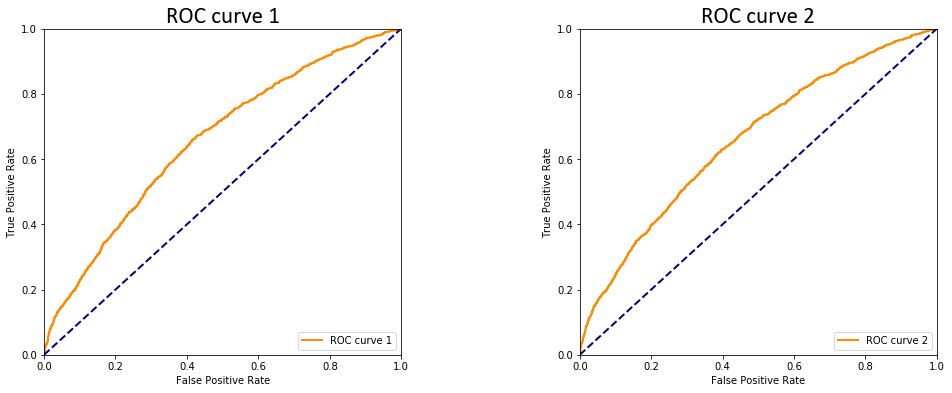

In [66]:
font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体

fig3 = plt.figure(figsize = (16,6))
lw = 2
ax1 = fig3.add_subplot(121)
ax1.plot(fpr1,tpr1,color="darkorange",lw=2, label="ROC curve 1")
ax1.plot([0,1],[0,1],color="navy",lw=lw, linestyle="--")
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.0)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve 1',fontdict=font2)
ax1.legend(loc="lower right")

ax2 = fig3.add_subplot(122)
ax2.plot(fpr2,tpr2,color="darkorange",lw=2, label="ROC curve 2")
ax2.plot([0,1],[0,1],color="navy",lw=lw, linestyle="--")
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC curve 2',fontdict=font2)
ax2.legend(loc="lower right")

plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

结论：   
1. 阈值为 0.8时，auc1 = 0.6477, auc2 = 0.6519，提示用2.3.2得到的特征训练LR模型略好于用2.3.1得到的特征。
2. 经试验发现，如果以上步骤不变，仅调节 colinearity 中的阈值，也就是相关系数大于多少的特征对要删去其一，会发现，  
阈值为 0.6时，auc1 = 0.6324, auc2 = 0.6447  
阈值为 0.7时，auc1 = 0.6398, auc2 = 0.6468  
阈值为 0.8时，auc1 = 0.6477, auc2 = 0.6519  
阈值为 0.9时，auc1 = 0.6556, auc2 = 0.6552  
阈值为 1.0时，auc1 = 0.6586, auc2 = 0.6583  
这似乎提示，不删除强相关的特征，即保留所有特征会更好？  
3. 改变 LR 的超参数C并不会引起 AUC值改变太多。（相关系数阈值0.8）   
C为  1 时，auc1 = 0.647744 , acu2 = 0.651925  
C为 10 时，auc1 = 0.647729 , acu2 = 0.651930  
C为100 时，auc1 = 0.647727 , acu2 = 0.651935   
所以并没有特别大的改观。  
4. 试过增大LR模型的max_iter，发现基本没有变化。（阈值0.8，C为1）   
max_iter为  100 时，auc1 = 0.647744 , acu2 = 0.651925
max_iter为 1000 时，auc1 = 0.647744 , acu2 = 0.651925


## 2.5 训练 LR 模型  

1. 沿用计算XGBOOST特征重要性时得到的数据集：将训练集data_tr进行train_test_split二八分（此函数里面有shuffle和stratify选项），得到字段部分和目标变量部分分类得X_tr_train, X_tr_test, y_tr_train, y_tr_test。然后，因为2.4中显示特征选择会降低AUC，所以此处不进行特征选择，而是使用所有特征进行训练。训练集X_tr_train，y_tr_train。验证集X_tr_test，y_tr_test。
2. LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”和“LR模型”组成管道。通过GridSearchCV进行对LR的超参数C进行交叉验证，粗选出最佳C。
3. 在最佳C下，LR模型对完整数据集X_tr_train，y_tr_train进行fit，得到最佳模型，然后对验证集X_tr_test，y_tr_test进行预测，并计算auc和ks评分。
4. 围绕粗选出的最佳C设置一个小范围，使用 hyperopt 进行精细的选择。得到最佳C。
5. 将完整训练集进行五折交叉验证（在最佳C下），得到5个 auc和ks值供参考。
6. 在最佳C下，对完整训练集X_tr,y_tr训练LR模型，得到的模型对未知样本集 X_te进行预测，保存预测结果 LRPre. 

### 2.5.1 准备数据集。
&ensp;&ensp;沿用计算XGBOOST特征重要性时得到的数据集：将训练集data_tr进行train_test_split二八分（此函数里面有shuffle和stratify选项），得到字段部分和目标变量部分分类得X_tr_train, X_tr_test, y_tr_train, y_tr_test。然后，因为2.4中显示特征选择会降低AUC，所以此处不进行特征选择，而是使用所有特征进行训练。 训练集X_tr_train，y_tr_train可用于之后的交叉验证求最佳超参数。验证集X_tr_test，y_tr_test可用于得到最佳超参数并训练出最佳模型后，用此模型对验证集进行预测，计算auc。

### 2.5.2 GridSearchCV 交叉验证粗取最佳超参数

In [69]:
# LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”和“LR模型”组成管道。
# 通过GridSearchCV对训练集X_tr_train，y_tr_train进行5折交叉验证，从而实现对LR的超参数C进行
# 交叉验证，选出最佳C。

# ks_score = make_scorer(ks_statistic,greater_is_better=True,needs_proba=False)
LR_parameter = {"penalty": "l2","tol": 1e-4,"class_weight": 'balanced', 
                'solver': 'liblinear','max_iter':100,'random_state':3}
pipe1 = Pipeline([ ("standard", StandardScaler()) ,
                  ("LR", LogisticRegression(**LR_parameter)) ])

# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid = dict(LR__C=[0.001,0.01,0.1, 1, 10, 100, 1000]) 

# scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
timestart = time.time()
grid_search = GridSearchCV( pipe1, param_grid=param_grid, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search.fit(X_tr_train,y_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.617 hours


In [70]:
# 返回最佳超参数值，可见最佳C是0.01
grid_search.best_params_  

{'LR__C': 0.01}

### 2.5.3 对验证集进行预测并求得AUC---法1

进行预测。法1  
  
说明：  
&ensp;&ensp;我是这样理解的，GridSearchCV 去 fit(X_tr_train,y_tr_train)时，首先按照cv=5的要求分成五折（按照GridSearchCV的规定，是分层抽样但不随机shuffle。好在我刚开始已经手动shuffle过了。则这样实现了“shuffle+分层”的抽样方法），然后，把第一种情况（4折训练集，1折验证集）包括它们对应的目标y值传给pipe，pipe里的StandardScaler先接触到 4折训练集+1折验证集，StandardScaler会对4折训练集进行 fit+transform标准化，然后把学到的均值方差应用到1折验证集上，对其也标准化（应该不会对目标变量y进行标准化，因为，查阅StandardScaler的文档，发现它的fit方法的参数里是有y的，但不会对y进行任何处理，我认为是StandardScaler为了兼容其它方法，比如这里的pipeline，还是保留了y参数，从而有一个传递的效果），然后，标准化后的4折训练集+1折验证集，以及不变的y 传递给LR模型，而且此时GridSearchCV 选定尝试超参数C=0.001，LR模型进行训练，得到在C=0.001下的模型，并对验证集进行预测，对比验证集真实结果，用scoring=”roc_auc”即auc标准，算得auc值。 后续过程参见GridSearchCV原理。总之，GridSearchCV会对每个超参数组合进行5次训练，得到5个score取平均，谁的平均score最高，则谁是最佳的超参数C值。  
&ensp;&ensp;grid_search.best_params_ 返回这个最佳C。  
&ensp;&ensp;另外，因为GridSearchCV设置 refit=true，所以得到最佳C后，会在整个数据集上再尝试，这时，整个数据集X_tr_train,y_tr_train给到了StandardScaler，它直接将X_tr_train标准化，保留y_tr_train不变，并记录了X_tr_train的均值方差标准。然后，把标准化的X_tr_train,y_tr_train给到了LR模型，在最佳C下对整个训练集训练出模型，这个模型存储在grid_search.best_estimator_。另外我认为，对于 GridSearchCV来说，“模型”这个概念指的是pipe，毕竟GridSearchCV的第一个参数我写的是pipe而非LR，所以，我认为这个最佳模型应该是pipe，即包含了StandardScaler和LR，其中，StandardScaler是对标准化的整个训练集进行fit得到的，所以我认为它里面是包含了整个训练集的均值方差。而LR是对整个标准化训练集在C为最佳C下训练得到的。  
&ensp;&ensp;然后，grid_search. predict_proba(X_tr_test)会用这个存储在grid_search.best_estimator_里的模型预测测试集X_tr_test，因为StandardScaler已经存储了整个训练集的均值方差，所以可以直接用在X_tr_test上。这样是对的。然后，把标准化后的X_tr_test传递给最佳LR模型，进行预测。  
&ensp;&ensp;grid_search. score(X_tr_test,y_tr_test) 同样是用grid_search.best_estimator_里的最佳模型对X_tr_test进行标准化，预测，评分，这里用的是scoring=”roc_auc”定义的auc分值。  

In [71]:
# 返回最佳模型。是在最佳超参数 C= 下，对整个训练集 X_tr_train，y_tr_train进行学习得到的模型。
grid_search.best_estimator_  

Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [72]:
# 返回使用最佳超参数值进行五折训练时，得到的 5个score的均值，且是 refit指定的 auc指标的均值。
# 可见，最佳C时，五折训练得到的五个模型对各自验证集预测的auc得分的均值为 0.6687 。
grid_search.best_score_  

0.6687085665187095

In [73]:
# 对测试集 X_tr_test 进行属于正类别1的概率预测
grid_search.predict_proba(X_tr_test)

array([[0.57849826, 0.42150174],
       [0.54401289, 0.45598711],
       [0.56817054, 0.43182946],
       ...,
       [0.75230456, 0.24769544],
       [0.57148205, 0.42851795],
       [0.79973481, 0.20026519]])

In [74]:
# 使用best_estimator_里的最佳模型对测试集样本进行预测并计算score。score指标使用 refit指定的auc指标。
# 可见，最佳模型对测试集预测的auc是0.67左右。
grid_search.score(X_tr_test,y_tr_test)

0.6736258454927472

In [75]:
# 算一下 ks 评分。可见， KS评分还是很低的。
ks_value = ks_statistic(np.array(y_tr_test),grid_search.predict_proba(X_tr_test)[:,1])
# 注意此处，千万不要把 左侧的变量的名字定义为 ks_statistic，否则算出值后，此变量会指向一个值，而非一个函数。
# 下一次再调用 ks_statistic时就会出错。犯过这个错了已经。
print("ks_value is: ",ks_value)

ks_value is:  0.2531851273014329


### 2.5.4 对验证集进行预测并求得AUC---法2

进行预测。法2  
  
说明：  
&ensp;&ensp;grid_search.best_params_ 得到了最佳C。然后，将之带入到pipe中，这时，pipe里的LR模型的C就固定了，然后，pipe.fit(X_tr_train,y_tr_train)，首先，StandardScaler接触到X_tr_train,y_tr_train，会对X_tr_train进行fit和transform，即进行标准化并记录X_tr_train的均值方差。然后，把标准化后的X_tr_train和未更改的y_tr_train给到LR，则LR会在最佳C下fit此数据，得到最佳模型。    
&ensp;&ensp;pipe.predict_proba(X_tr_test)是用次最佳模型对X_tr_test进行预测，首先还是StandardScaler接触到X_tr_test，但它已经存储了X_tr_train的均值方差，所以直接应用到X_tr_test上即可，然后把标准化的X_tr_test给到了LR模型进行预测。  
&ensp;&ensp;然后调用 roc函数计算auc。  
&ensp;&ensp;我个人认为法1和法2的predict_proba 和 auc 结果应该是相同的。事实却是是相同的。证明法1法2等效。


In [76]:
# 返回最佳超参数值，可见最佳C是0.01
grid_search.best_params_  

{'LR__C': 0.01}

In [77]:
# 这里使用了将 C值代入 pipe，得到最终 pipe的方式。用 pipe 对测试集样本进行预测，计算auc。

pipe1.set_params(LR__C=0.01)  # 最佳超参数值代入pipe里
pipe1.fit(X_tr_train,y_tr_train)  # 整个训练集 X_tr_train，y_tr_train进行学习得到的模型
pipe1.predict_proba(X_tr_test) # 可见这个结果和法 1 完全相同。

array([[0.57849826, 0.42150174],
       [0.54401289, 0.45598711],
       [0.56817054, 0.43182946],
       ...,
       [0.75230456, 0.24769544],
       [0.57148205, 0.42851795],
       [0.79973481, 0.20026519]])

In [78]:
# 可见这个结果和法 1 完全相同。
roc_auc_score(y_tr_test, pipe1.predict_proba(X_tr_test)[:,1])

0.6736258454927472

In [79]:
# 算一下 ks 评分。KS评分与法1相同，还是很低的。

ks_value2 = ks_statistic(np.array(y_tr_test),pipe1.predict_proba(X_tr_test)[:,1]) 
print("ks_statistic value is: ",ks_value2)

ks_statistic value is:  0.2531851273014329


### 2.5.5 查看并分析详细信息

### 2.5.6 hyperopt 求取最佳超参数

&ensp;&ensp;GridSearchCV只是求出了超参数C的大致范围，即0.001到0.1之间。我们把C的范围限制在这里，通过hyperopt在这个参数范围内寻找最佳C值。首先，使用训练LR时使用的二八分数据：训练集X_tr_train，y_tr_train, 测试集X_tr_test，y_tr_test。按照hyperopt的用法，需要自定义一个函数，给出超参数范围，hyperopt在这个范围内选择值，然后代入这个函数，求得函数值，使函数值最小的那个就是最佳超参数。我们这样定义函数LRfunction：对训练集X_tr_train，y_tr_train进行五折划分，在某C下，分别学得5个模型，用模型对各自的测试集预测并求auc，求得5个auc值的均值的负数，作为函数返回值，可见，此值越小，说明 auc均值越大，说明这个C固定值越佳。

In [81]:
# 使用训练LR模型使用的二八分数据：训练集X_tr_train，y_tr_train, 测试集X_tr_test，y_tr_test

print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)


In [82]:
# 然后，对训练集X_tr_train，y_tr_train进行一次性五折划分。
# Xt 存储了 5个二维array，分别是5份训练集。  
# Xv 存储了 5个二维array，分别是对应的5份验证集。
# Yt 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yv 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=2)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xt = []
Yt = []
Xv = []
Yv = []
for train_index, validation_index in skf.split(X_tr_train.values,y_tr_train.values):  
    Xt.append(X_tr_train.values[train_index])
    Yt.append(y_tr_train.values[train_index])
    Xv.append(X_tr_train.values[validation_index])
    Yv.append(y_tr_train.values[validation_index])

In [83]:
Xt

[array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         5.00000000e+00, 6.05015990e+01, 5.93161749e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         4.00000000e+00, 4.14421640e+01, 5.92919829e+09],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
         3.00000000e+00, 4.38137420e+01, 5.92911189e+09],
        ...,
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         8.00000000e+00, 1.54479904e+02, 5.92686549e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         2.00000000e+00, 4.01248630e+01, 5.92755669e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         7.00000000e+00, 1.22143875e+02, 5.92695189e+09]]),
 array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         2.00000000e+00, 4.26317480e+01, 5.91563349e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         3.00000000e+00, 3.98147080e+01, 5.92824789e+09],
        [0.00000000e+00, 

In [84]:
Yt

[array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 1.])]

In [85]:
# 此段代码用 hyperopt 加 交叉验证 选择 LR 模型的最优超参数。
#（5折交叉验证）将此训练集一次性随机分成5份，以其中4份作为训练集，1份作为验证集。给模型代入一组固定的超参数值，然后，
# 用此模型对这4份训练集进行学习，用学得的模型对那1份验证集进行预测，然后，对比验证集的预测值和真实值（用Score函数，计算AUC值），
# 得到score。因为是5折，所以可以学得5个模型，进行5次相应预测，得到5个score值（这5个模型用的都是同一组超参数值），
# 求这5个score的平均值的负值，即 -np.mean(score)。将这个过程构成函数 LRfunction，这个-np.mean(score)就是LRfunction的返回值，
# 是hyperopt的评价依据。然后，定义超参数空间space，设置搜索算法algo参数，然后，使用fmin方法在超参数空间中选择能使 -np.mean(score)
# 值最小的那组超参数值。这样，就得到了最佳超参数值。
# 此处，LR 模型 只用 hyperopt 加 交叉验证 选择 "C" 这一个超参数的最优值。
# 另外，还使用了 trials 捕捉了在每一次尝试中使用的 C值 和 对应得到 的-np.mean(score)值（即loss列）


LR_parameter_space ={'C':hp.uniform('C', 0.001, 0.1)}  
# 
# 对 LR 模型来说，只对 C 这一个超参数调参。我本来用的是 hp.loguniform("C", -6.9, -2.3)，
# 这个根据粗选结果来设定。exp(-6.9)=0.001, exp(-4.6)=0.01,  exp(-2.3)=0.1 
# [exp(-6.9),exp(-2.3)]间的log分布。但我发现这样不太好，因为这个分布对 0.001到0.01之间的数值
# 尝试的比较多，而对 0.01到 0.1 之间的尝试的很少。所以我改成了均匀分布。


def LRfunction(args):
    # args是LR_parameter_space
    LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                    'random_state':5,'max_iter':100,'tol':0.005} 
                    # 这个随机数是因为liblinear使用了随机过程。另外max_iter需要增加么？
    LR_parameter.update(args)
    clf = LogisticRegression(**LR_parameter)
   
    score = []
    for i in range(len(Xt)):
        # 标准化数据集
        scaler = StandardScaler()
        scaler.fit(Xt[i])
        Xti_std = scaler.transform(Xt[i])  # std表示标准化过
        Xvi_std = scaler.transform(Xv[i])
        # 训练模型
        clf.fit(Xti_std,Yt[i])
        # 若此时 print('LR_classes:',clf.classes_) ， 结果为：array([0, 1], dtype=int64)，即类别 0 先，类别 1 后。
        # 预测验证集
        proba_prediction = clf.predict_proba(Xvi_std)
        # 所得到的 proba_prediction 是一个 二维 array，第一列是预测每个样属于第 0 类的概率，
        # 第二列是每个样属于第1类的概率。(与clf.classes_ 顺序保持一致)
        
        score.append(roc_auc_score(Yv[i],proba_prediction[:,1]))  
        # 所以这里是 proba_prediction[:,1] 取第二列。
  
    return -np.mean(score)

timestart = time.time()
LRtrials = Trials()
LRbest = fmin(fn = LRfunction, space = LR_parameter_space, algo=tpe.suggest, max_evals=30,trials=LRtrials)  # max_evals表示尝试30个C值，从中找最好的。可以先设为2，尝试一下。
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))


Time: 0.875 hours


In [86]:
# 这里记录了 hyperopt 在循环计算时的详细情况。因为 fmin中max_evals=30，也就是要从给出的C的范围（space参数）里选出30个C值进行试验。
# LRtrials.trials 是一个 list，里面有三个字典，即尝试 30 个C值时的详细情况。
# 每个字典里，misc是一个复合字典，里面的 vals 记录了尝试的 C值。

LRtrials.trials

[{'book_time': datetime.datetime(2019, 5, 5, 14, 28, 31, 871000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [0]},
   'tid': 0,
   'vals': {'C': [0.051312253891688836]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 5, 14, 30, 38, 921000),
  'result': {'loss': -0.6647268659759156, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 0,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 5, 14, 30, 38, 926000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [1]},
   'tid': 1,
   'vals': {'C': [0.01583310860869715]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 5, 14, 32, 4, 227000),
  'result': {'loss': -0.6660431043411293, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 1,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 5, 14, 32, 4, 235000),
  'exp_key': None,
  'misc': {'cmd': ('do

In [87]:
# LRtrials.losses() 为一个 list，里面有30个值，分别是尝试每个C值时，LRfunction 的返回值，即 5折交叉验证求得的5个score的均值的负数。

LRtrials.losses()

[-0.6647268659759156,
 -0.6660431043411293,
 -0.6659048687503877,
 -0.6651531747929157,
 -0.6651488012910984,
 -0.6655512344049385,
 -0.6642534105303828,
 -0.665045976036176,
 -0.6654222129425611,
 -0.6666950808800338,
 -0.6651505011285825,
 -0.6644099103175451,
 -0.6656660688433936,
 -0.664140182869174,
 -0.664233929155664,
 -0.6648171686495639,
 -0.666901524574961,
 -0.6643586950404371,
 -0.6651072983638426,
 -0.6647102143884753,
 -0.666890447910247,
 -0.6668263740678626,
 -0.6667191857579353,
 -0.666941884502366,
 -0.6662714640934977,
 -0.6664307211684525,
 -0.6645608094885601,
 -0.6669598648020906,
 -0.6654348995531414,
 -0.6648630872833035]

In [88]:
# 将结果组成 dataframe 表 LRop。
# 第一列为 尝试的 C值，第二列是 将此C代入 LRfunction 后求出的 平均auc 值。此值越大，说明此 C 越佳。（已按auc_mean从大到小排序）
# 使得 平均auc值最大的那个 C，就是 hyperopt 选出的最佳 C。即为首行 C 。

LRop = pd.concat([pd.DataFrame([sum(list(LRtrials.trials[j]["misc"]["vals"].values()), []) for j in range(len(LRtrials))],
                                 columns = list(LRtrials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({"auc_mean":[np.abs(i) for i in LRtrials.losses()]})], axis = 1).sort_values(by=["auc_mean"],ascending=False)

In [89]:
LRop

,C,auc_mean
27,0.003316,0.666960
23,0.002957,0.666942
16,0.002569,0.666902
20,0.002538,0.666890
21,0.002205,0.666826
22,0.007139,0.666719
9,0.007290,0.666695
25,0.010579,0.666431
24,0.012625,0.666271
1,0.015833,0.666043


In [90]:
# 现在我们已经确定出了最佳的C值：0.005。然后在最佳C下对整个训练集X_tr_train, y_tr_train进行学习，学得的模型对X_tr_test, y_tr_test 进行预测。
# 可见，对验证集进行预测算auc，值为 0.67，并不高。ks 评分为0.25，也不高。

args = {"C":0.005}
LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                'random_state':5,'max_iter':100,'tol':0.005} 
LR_parameter.update(args)

# 之前 scaler2 已经 对 X_tr_train 和 X_tr_test 进行过了标准化如下，可以拿来直接用。
# scaler2 = StandardScaler()
# scaler2.fit(X_tr_train)
# X_tr_train_standard = scaler2.transform(X_tr_train)
# X_tr_test_standard = scaler2.transform(X_tr_test)

modelLR3 = LogisticRegression(**LR_parameter)
modelLR3.fit(X_tr_train_standard, y_tr_train)
proba_prediction3 = modelLR3.predict_proba(X_tr_test_standard)

# 计算AUC
roc_auc_score(y_tr_test, proba_prediction3[:,1])

0.6742869445263973

In [91]:
 # 算一下KS评分。
ks_statistic(np.array(y_tr_test), proba_prediction3[:,1]) 

0.25432697291306183

### 2.5.7 交叉验证  
&ensp;&ensp;以上过程是建立在一次性二八分，用八份去通过GridSearchCV+hyperopt得到最佳C，然后在此C下对这八份进行学习得到最佳模型，然后用最佳模型对那三份进行预测并计算AUC和KS。  
&ensp;&ensp;一次性二八分会否太单一？我认为可以在此C下使用交叉验证，多算几个验证分数。也就是把整个训练集X_tr, y_tr进行五折划分，在此C下学得5个模型，这5个模型对各自的验证集进行预测，得到5个auc和ks评分。可以看看这5个评分，算一下均分。

In [92]:
# 使用 cross_val_score 进行交叉验证
# 交叉验证显示，在最佳C下，训练的LR模型所得的auc评分也还在 0.65 左右，比较低。

pipe2 = make_pipeline(StandardScaler(), LogisticRegression(**LR_parameter))  # LR_parameter 是固定参数+最佳超参数 C
scores = cross_val_score(pipe2, X_tr, y_tr,cv = 5, scoring="roc_auc")  # 或试试cv=10
print("5Fold scores :", scores)
print("5Fold mean score :", np.mean(scores))

5Fold scores : [0.66117415 0.67825853 0.66142954 0.6396072  0.63259252]
5Fold mean score : 0.6546123878170597


### 2.5.8 训练最终LR模型并预测未知样本集

In [93]:
# 训练最终LR模型并预测未知样本集

scaler3=StandardScaler()
scaler3.fit(X_tr)
X_tr_std = scaler3.transform(X_tr)  # std代表标准化
X_te_std = scaler3.transform(X_te)
modelLR4 = LogisticRegression(**LR_parameter) # LR_parameter 是固定参数+最佳超参数 C
modelLR4.fit(X_tr_std, y_tr)
proba_prediction4 = modelLR4.predict_proba(X_te_std)

In [94]:
# 将预测结果整合成表

LRpre = pd.DataFrame(proba_prediction4[:,1],index=X_te.index,columns=["positive_proba"]).reset_index()
LRpre.columns = ["userid","probability"]  # 按官网提交示例修改列名

In [96]:
# 保存预测结果

LRpre.to_csv(r'F:\RiskPre2\result\LRpre.csv',index=False)

In [97]:
# 保存模型

joblib.dump(modelLR4, r'F:\RiskPre2\result\modelLR4.pkl')

['F:\\RiskPre2\\result\\modelLR4.pkl']

In [98]:
# 保存字段变量部分 X 和目标变量部分 Y 分开的： X_tr, y_tr, X_te, y_te

f1 = open(r'F:\RiskPre2\result\data_fill_XY.pkl', "wb")
pickle.dump(X_tr, f1, protocol=-1)
pickle.dump(y_tr, f1, protocol=-1)
pickle.dump(X_te, f1, protocol=-1)
pickle.dump(y_te, f1, protocol=-1)
f1.close()

In [99]:
# 保存训练集X_tr, y_tr进行二八划分得到的： X_tr_train, X_tr_test, y_tr_train, y_tr_test

f2 = open(r'F:\RiskPre2\result\split2_8.pkl', "wb")
pickle.dump(X_tr_train, f2, protocol=-1)
pickle.dump(y_tr_train, f2, protocol=-1)
pickle.dump(X_tr_test, f2, protocol=-1)
pickle.dump(y_tr_test, f2, protocol=-1)
f2.close()